<a href="https://www.kaggle.com/code/magedmahmoud/mastering-sentiment-analysis?scriptVersionId=91949569" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Frame the problem and look at the big picture:
In this notebook we use various techniques and recent methods in text classification from rule based sentiment analysis to Machine learning based Sentiment Analysis.

**This Notebook will give step by step approach to NLP Sentiment Analysis from basic models to deep learning models** 

### What is Sentiment Analysis?
Sentiment Analysis is a NLP technique used to interpret the emotions, comments and reviews (Positive, Negative or Natural) behind text data.
### Applications of Sentiment Analysis:
* Social Media Analysis
* Public Sentiment about products
* Content Moderation
* Stock Market Analysis


**Some Code here is imported from **SOHAIL notebook****

# Get The Data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/googles-trained-word2vec-model-in-python/GoogleNews-vectors-negative300.bin.gz
/kaggle/input/googles-trained-word2vec-model-in-python/GoogleNews-vectors-negative300.bin
/kaggle/input/glove6b50dtxt/glove.6B.50d.txt
/kaggle/input/glove2word2vec/glove_w2v.txt
/kaggle/input/financial-sentiment-analysis/data.csv
/kaggle/input/fast-text-embeddings-without-subwords/wiki-news-300d-1M.vec/wiki-news-300d-1M.vec
/kaggle/input/fast-text-embeddings-without-subwords/crawl-300d-2M.vec/crawl-300d-2M.vec


## Import Files and Libraries

In [2]:
pip install tensorflow_text

     |████████████████████████████████| 4.9 MB 893 kB/s            
     |████████████████████████████████| 497.5 MB 21 kB/s              
     |████████████████████████████████| 14.5 MB 38.1 MB/s            
     |████████████████████████████████| 1.4 MB 48.3 MB/s            
     |████████████████████████████████| 5.8 MB 47.5 MB/s            
     |████████████████████████████████| 462 kB 50.5 MB/s            
     |████████████████████████████████| 2.1 MB 47.8 MB/s            
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.6.2
    Uninstalling tensorflow-2.6.2:
      Successfully uninstalled tensorflow-2.6.2
ERROR: pip's dependency res

In [3]:
# nltk imports
from nltk.tokenize import word_tokenize # tokenize the text == the text is splitted into words in list
from nltk.corpus import stopwords # this contain common stop words that has no effect in analysis
from nltk.stem import WordNetLemmatizer #Lemmatization is the process of grouping together the different inflected forms of a word so they can be analyzed as a single item
# sklearn imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # bags of words and TF IDF
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix , make_scorer# classification Metrics
from sklearn.naive_bayes import MultinomialNB # Multiclassification
from sklearn.preprocessing import MinMaxScaler 
from sklearn import svm
from sklearn.model_selection import StratifiedKFold # For stratified splitting (helpful in imbalanced data)
from sklearn.preprocessing import LabelBinarizer # for Categorical features
from sklearn.model_selection import GridSearchCV # for tuning parameters
from sklearn.model_selection import train_test_split # splitting dataset
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC
from sklearn import metrics
from sklearn import pipeline
from sklearn import linear_model
############################################################################
from gensim.models import KeyedVectors # to save and load vectors
import string
import re
import pandas as pd
import numpy as np
import xgboost as xgb
import catboost as cbt
# tensorflow and keras
import keras
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence, text
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [4]:
df = pd.read_csv('/kaggle/input/financial-sentiment-analysis/data.csv')

df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [5]:
df.shape

(5842, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [7]:
unique_sentiments = df.Sentiment.unique()
unique_sentiments

array(['positive', 'negative', 'neutral'], dtype=object)

<AxesSubplot:>

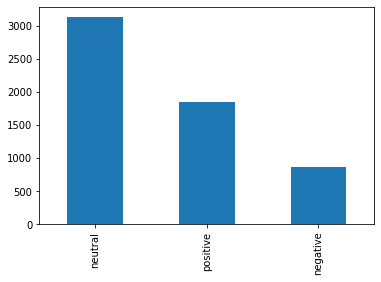

In [8]:
df.Sentiment.value_counts().plot.bar()

In [9]:
# mapping to the sentiment column 

dicto = {'positive': 1, 'neutral': 0 , 'negative': -1}

df.Sentiment = df.Sentiment.map(dicto)

In [10]:
# Classical models function
def classical_model(df = df,bow = False,TFIDF = False,Ngram = False, model = linear_model.LogisticRegression(solver = 'liblinear')): 
    '''
    this function automate the classical models to train and evaluate Sentiment Analysis Models
    firstly: you must specify one type of text vectorization (bow, TFIDF, Ngram).
    bow = True or False          # bag of words
    TFIDF = True or False
    Ngram = shape of Ngram_range (...,...)
    model should be specified also to define which model will be trained
    '''
    df['kfold'] = -1
    
    df = df.sample(frac=1).reset_index(drop= True) # this shuffle data and reset index
    
    y = df.Sentiment.values
    
    # Intitiate kfold class from model_selection module
    
    kf = StratifiedKFold(n_splits = 5)
    
    for f, (t_, v_) in enumerate(kf.split(X=df, y=y)):
        df.loc[v_, 'kfold'] = f
    
    if bow:
        count_vec = CountVectorizer(tokenizer = word_tokenize, token_pattern=None)
    if TFIDF:
        count_vec = TfidfVectorizer(tokenizer = word_tokenize, token_pattern=None)
    if Ngram:
        count_vec = CountVectorizer(tokenizer = word_tokenize, token_pattern=None, ngram_range = Ngram)
    # we go over the folds
    for fold_ in range(5):
        train_df = df[df.kfold != fold_].reset_index(drop=True)
        test_df = df[df.kfold == fold_].reset_index(drop=True)
        count_vec.fit(train_df.Sentence)
        
        xtrain = count_vec.transform(train_df.Sentence)
        xtest = count_vec.transform(test_df.Sentence)
        
        model.fit(xtrain,train_df.Sentiment)
        
        preds = model.predict(xtest)
        
        accuracy_precision = precision_score(test_df.Sentiment, preds, average='micro')
        accuracy_recall = recall_score(test_df.Sentiment, preds, average = 'micro')
        
        print('precision score:', accuracy_precision)
        print('recall score:', accuracy_recall)
        print("========================================================")
        
    print(classification_report(test_df.Sentiment, preds))

# Model-1 Logistic + BOW

In [11]:
#Baseline model let's start with a logistic regression model since it is the fastest for high dimensional sparse data

classical_model(df, bow =True,model=linear_model.LogisticRegression(solver = 'liblinear'))

precision score: 0.6766467065868264
recall score: 0.6766467065868264
precision score: 0.6911890504704876
recall score: 0.6911890504704876
precision score: 0.6986301369863014
recall score: 0.6986301369863014
precision score: 0.6892123287671232
recall score: 0.6892123287671232
precision score: 0.6797945205479452
recall score: 0.6797945205479452
              precision    recall  f1-score   support

          -1       0.26      0.22      0.24       172
           0       0.71      0.78      0.74       626
           1       0.80      0.72      0.76       370

    accuracy                           0.68      1168
   macro avg       0.59      0.57      0.58      1168
weighted avg       0.67      0.68      0.67      1168



We can see that labels **1,0 have more than 70 percent** score but label **-1 score is pretty low**, hence we can conclude that we need to go on modelling untill these scores get better.

# Model 2 NaiveBayes + BOW

In [12]:
# Lets try with NaiveBayes model 

classical_model(bow = True,model = MultinomialNB())

precision score: 0.6946107784431138
recall score: 0.6946107784431138
precision score: 0.6963216424294268
recall score: 0.6963216424294268
precision score: 0.699486301369863
recall score: 0.699486301369863
precision score: 0.6806506849315068
recall score: 0.6806506849315068
precision score: 0.7148972602739726
recall score: 0.7148972602739726
              precision    recall  f1-score   support

          -1       0.49      0.32      0.39       172
           0       0.73      0.86      0.79       626
           1       0.75      0.65      0.69       370

    accuracy                           0.71      1168
   macro avg       0.66      0.61      0.63      1168
weighted avg       0.70      0.71      0.70      1168



It is evident that the for **label -1 the metrics values little improved** so this model will be the new baseline model for this problem.

# Model-3 Naive Bayes with TFIDF

In [13]:
# Now lets try with TF-IDF vectorizer instead of bag of words to MultinomialNB().

classical_model(model= MultinomialNB(),TFIDF=True)

precision score: 0.6467065868263473
recall score: 0.6467065868263473
precision score: 0.6390076988879384
recall score: 0.6390076988879384
precision score: 0.6541095890410958
recall score: 0.6541095890410958
precision score: 0.6618150684931506
recall score: 0.6618150684931506
precision score: 0.6472602739726028
recall score: 0.6472602739726028
              precision    recall  f1-score   support

          -1       1.00      0.03      0.06       172
           0       0.63      0.98      0.77       626
           1       0.72      0.37      0.49       370

    accuracy                           0.65      1168
   macro avg       0.78      0.46      0.44      1168
weighted avg       0.71      0.65      0.57      1168



also, the **label -1 metrics recall score is unsatisfied**  

# Model-4 Naive Bayes with Ngrams

In [14]:
# Now to the baseline bag of word Naivebayes model lets apply Ngrams  and compare the results.

# Lets try with NaiveBayes model 

classical_model(model = MultinomialNB(), Ngram=(1,3))

precision score: 0.6467065868263473
recall score: 0.6467065868263473
precision score: 0.6449957228400343
recall score: 0.6449957228400343
precision score: 0.6626712328767124
recall score: 0.6626712328767124
precision score: 0.6883561643835616
recall score: 0.6883561643835616
precision score: 0.651541095890411
recall score: 0.651541095890411
              precision    recall  f1-score   support

          -1       0.22      0.14      0.17       172
           0       0.68      0.82      0.74       626
           1       0.74      0.60      0.66       370

    accuracy                           0.65      1168
   macro avg       0.55      0.52      0.53      1168
weighted avg       0.63      0.65      0.63      1168



So the **ngrams has even decreased the metrics** value.Hence it is evident that the baseline model is still the best one till now

# Text processing

I will **not remove stopwords** in this because it might change the context of the sentence.

e.g **"He is not a good person"** will be changed into **" 'He' , 'good', 'person'"** which is the complete opposite of the sentence.

In [15]:
# Now lets do some cleaning on the text data and apply it to baseline model and compare the accuracies.



def process_text(text):
    
    text = word_tokenize(text) # tokenize words in text
    text = [re.sub('[^A-Za-z]+', '', word) for word in text] # this line substitutes any white space before the word by removing the space
    text = [word.lower() for word in text if word.isalpha()] # lower each word in text
    text = [WordNetLemmatizer().lemmatize(word) for word in text] # lemmatization of words, so when see persons an person, both are dealt as one word person
    text = ' '.join(text) # join words into text again
    return text

In [16]:
text = 'He is not a good person'
token_text = word_tokenize(text)
[ word for word in token_text if word not in stopwords.words('english')]

['He', 'good', 'person']

In [17]:
df.Sentence = df.Sentence.apply(process_text) # this line applies process_text function to Sentence in dataset

# Model 5 cleaned text Naive Bayes BOW and 

In [18]:
#Now lets try this on our baseline MultinomialNB bagofwords model

classical_model(model = MultinomialNB(),bow = True)

precision score: 0.7048759623609923
recall score: 0.7048759623609923
precision score: 0.7159965782720273
recall score: 0.7159965782720273
precision score: 0.7071917808219178
recall score: 0.7071917808219178
precision score: 0.7003424657534246
recall score: 0.7003424657534246
precision score: 0.6943493150684932
recall score: 0.6943493150684932
              precision    recall  f1-score   support

          -1       0.43      0.33      0.38       172
           0       0.73      0.84      0.78       626
           1       0.73      0.62      0.67       370

    accuracy                           0.69      1168
   macro avg       0.63      0.60      0.61      1168
weighted avg       0.68      0.69      0.68      1168



after some text cleaning **we beat our baseline model by small margin** hence the above model will be our new baseline model.

Now lets go into **word embeddings** 

In the above models each word token is converted into integer tokens by (BOW and TFIDF) now lets convert these **integer tokens into vectors.**

# Model 6 Fastext vector with Naive Bayes Baseline 

In [19]:
# In this model we will use fastText vectors and also convert each word vector in sentence vector.

#The code is taken from https://fasttext.cc/docs/en/english-vectors.html, this code splits each vector by 
# space and return for more info go through the above linl
 
def sentence_to_vec(s, embedding_dict, tokenizer):
    
    words = tokenizer(s)
    
    embedding_list = []
    for w in words:
        
        if w in embedding_dict:
            embedding_list.append(embedding_dict[w])
            
    # if we dont have any vectors, then return zeros
    if len(embedding_list) == 0:
        return np.zeros(300)
    
    #convert list of embeddings into an array
    embedding_list = np.array(embedding_list)
    #calculate sum over axis = 0 (This will convert the word vectorrs to sentence vectors)
    v = embedding_list.sum(axis=0)
    
    #return normalized vector
    return v

df = df.sample(frac=1).reset_index(drop=True)
y = df.Sentiment.values

df.drop('kfold', axis=1, inplace = True)

kf = StratifiedKFold(n_splits = 5)

#load embeddings into memory
print("Loading embeddings")
embeddings = KeyedVectors.load_word2vec_format('/kaggle/input/fast-text-embeddings-without-subwords/crawl-300d-2M.vec/crawl-300d-2M.vec')
    
#create sentence embeddings
print("creating sentence vectors")
vectors = []
for sentence in df.Sentence.values:
    vectors.append(         
       sentence_to_vec(s = sentence, embedding_dict= embeddings, tokenizer = word_tokenize)
    )
vectors = np.array(vectors)
    
for fold_,(train_, valid_) in enumerate(kf.split(X=df, y=y)):
        print("fold: ", fold_)
        
        xtrain = vectors[train_,:]
        ytrain = y[train_]
        
        xtest = vectors[valid_,:]
        ytest = y[valid_]
        
        scaler = MinMaxScaler()
        
        xscaled_train = scaler.fit_transform(xtrain)
        xscaled_test = scaler.transform(xtest)
        
        model = MultinomialNB()
    
        model.fit(xscaled_train,ytrain)
    
        y_pred = model.predict(xscaled_test)
    
        pres_score = precision_score(ytest, y_pred, average='micro')
    
        rec_score = recall_score(ytest, y_pred, average='micro')
    
        print('precision and recall scores:', pres_score, rec_score)
        print("======================================================")
    
print(classification_report(ytest, y_pred, labels=[1,-1,0]))

Loading embeddings
creating sentence vectors
fold:  0
precision and recall scores: 0.5372112917023096 0.5372112917023096
fold:  1
precision and recall scores: 0.5380667236954663 0.5380667236954663
fold:  2
precision and recall scores: 0.5376712328767124 0.5376712328767124
fold:  3
precision and recall scores: 0.5376712328767124 0.5376712328767124
fold:  4
precision and recall scores: 0.535958904109589 0.535958904109589
              precision    recall  f1-score   support

           1       0.50      0.00      0.01       370
          -1       0.00      0.00      0.00       172
           0       0.54      1.00      0.70       626

    accuracy                           0.54      1168
   macro avg       0.35      0.33      0.23      1168
weighted avg       0.45      0.54      0.38      1168



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Whoa! It is our worst performing model so far! What should we do now? Should we ask muppets to save us? No! we will keep on trying with other models and methods.Thats what data scientists do!**

# Model 7 - Glove vectors with Baseline model

In [20]:
class Word2VecVectorizer:
    def __init__(self, model):
        print("Loading in word vectors...")
        self.word_vectors = model
        print("Finished loading in word vectors")
    
    def fit(self, data):
        pass
    
    def transform(self, data):
        # determine the dimensionality of vectors
        v = self.word_vectors.get_vector('king')
        self.D = v.shape[0]

        X = np.zeros((len(data), self.D))
        n = 0
        emptycount = 0
    
        for sentence in data:
            tokens = sentence.split()
            vecs = []
            m = 0
            for word in tokens:
                try:
                    vec = self.word_vectors.get_vector(word)
                    vecs.append(vec)
                    m += 1
                except KeyError:
                    pass
            if len(vecs) > 0:
                vecs = np.array(vecs)
                X[n] = vecs.mean(axis=0)
            else:
                emptycount += 1
            n += 1
        print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
        return X


    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

In [21]:
from gensim.models import KeyedVectors

word2vec_output_file = '/kaggle/input/glove2word2vec/glove_w2v.txt'

model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary = False)

Xtrain,Xtest,ytrain,ytest = train_test_split(df.Sentence, df.Sentiment, test_size = 0.2, random_state = 42)

In [22]:
#we create a Vectorizer object that will help us to transform our reviews to vectors, a numerical representation. 
#Then we can use those vectors to feed our classifier.

vectorizer = Word2VecVectorizer(model)

X_train = vectorizer.fit_transform(Xtrain)
y_train = ytrain

X_test = vectorizer.transform(Xtest)
y_test = ytest

Loading in word vectors...
Finished loading in word vectors
Numer of samples with no words found: 0 / 4673
Numer of samples with no words found: 0 / 1169


In [23]:
# Define the parameters to tune
parameters = { 
    'C': [1.0, 10],
    'gamma': [1, 'auto', 'scale']
}

model = GridSearchCV(SVC(kernel='rbf'), parameters, cv=5, n_jobs=-1)

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.45      0.27      0.34       172
           0       0.72      0.85      0.78       628
           1       0.74      0.66      0.70       369

    accuracy                           0.70      1169
   macro avg       0.64      0.59      0.61      1169
weighted avg       0.69      0.70      0.69      1169



**Model 7 is our best performing model,then model 5, lets do some hyperparameter tuning before we move on to deep learning models**

# Model # Hyperparameter tuning best models

In [24]:
# model 5 Tuning
def scoring(y_train,y_pred):
    return f1_score(y_train,y_pred,average='weighted')

count_vec = CountVectorizer(tokenizer = word_tokenize, token_pattern = None)

X_train = count_vec.fit_transform(df.Sentence)

parameters = {'alpha': [0.001,0.01,0.1,0.2,0.3,0.5,0.7,1,1.5,1.6,1.8,10,100]}

model = MultinomialNB()

grid_search = GridSearchCV(model , parameters, cv=5, scoring = make_scorer(scoring), n_jobs = -1)

grid_result = grid_search.fit(X_train, df.Sentiment)

print('Best params: ', grid_result.best_params_)
print('Best score: ', grid_result.best_score_)



Best params:  {'alpha': 1}
Best score:  0.6979798529675103


In [25]:
# Lets also check svm hyperparameters using pipelines

df = df.sample(frac=1).reset_index(drop=True)



count_vec = CountVectorizer(tokenizer = word_tokenize, token_pattern = None)

X_train = count_vec.fit_transform(df.Sentence)

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf','linear']}
 
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 1, cv=5, scoring = make_scorer(scoring), n_jobs = -1)
 
# fitting the model for grid search
grid.fit(X_train, df.Sentiment)

print('Best params: ', grid.best_params_)
print('Best score: ', grid.best_score_)



Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  8.8min finished


Best params:  {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
Best score:  0.6924175105868348


**The model has performed worser than the previous above model, we can also create different pipelines of different machine learning models and compare them with both BOW and tfidf models**

**More models including deep learning models are yet to come**


# Model- 8 LSTM using glove word2vec

In [26]:
# loading pretrained google news word2vec embedding 300D
from gensim.models import KeyedVectors
word2vec_pretrained = KeyedVectors.load_word2vec_format("../input/googles-trained-word2vec-model-in-python/GoogleNews-vectors-negative300.bin",binary=True)
word2vec_pretrained_dict = dict(zip(word2vec_pretrained.key_to_index.keys(), 
                                    word2vec_pretrained.vectors))

In [27]:
list(word2vec_pretrained_dict.values())[0].shape

(300,)

In [28]:
df['Sentence'] = df['Sentence'].apply(process_text)

X_train,X_test,y_train,y_test = train_test_split(df.Sentence, df.Sentiment, test_size = 0.2, random_state = 42)

In [29]:
y_train_enc = np_utils.to_categorical(y_train, 3)
y_test_enc = np_utils.to_categorical(y_test, 3)

In [30]:
y_train_enc

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [31]:
token = tf.keras.preprocessing.text.Tokenizer(num_words=None)

token.fit_on_texts(list(X_train) + list(X_test)) # fits tokens on texts
xtrain_seq = token.texts_to_sequences(X_train) # text to sequences converts the sentence words to number sequences
xtest_seq = token.texts_to_sequences(X_test)

#zero pad sequences 

xtrain_pad = sequence.pad_sequences(xtrain_seq) # zero padding all sentences to have the same shape as the largest one
xtest_pad = sequence.pad_sequences(xtest_seq)

word_index = token.word_index # returns the word index that have been tokenized

In [32]:
#create embedding matrix for words that we have in dataset

embedding_matrix = np.zeros((len(word_index)+1, 300))
for word,i in word_index.items():
    embedding_vector = word2vec_pretrained_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        

In [33]:
# Build Custom Metrics (F1-Score)
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m_():
    def f1_m(y_true, y_pred):
        precision = precision_m(y_true, y_pred)
        recall = recall_m(y_true, y_pred)
        return 2*((precision*recall)/(precision+recall+K.epsilon()))
    return f1_m


In [34]:
# A simple LSTM with two dense layers

model = Sequential()
model.add(Embedding(len(word_index)+1,300,weights=[embedding_matrix], trainable = False))

model.add(SpatialDropout1D(0.3))
model.add(LSTM(300, dropout = 0.3, recurrent_dropout = 0.3))

model.add(Dense(1024 , activation = 'relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.8))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = [f1_m_()])

2022-04-02 22:42:14.360990: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-04-02 22:42:14.382937: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [35]:
model.fit(xtrain_pad, y=y_train_enc, batch_size = 512, epochs =10, verbose=1, validation_data = (xtest_pad, y_test_enc))

Epoch 1/10


2022-04-02 22:42:17.863820: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 30720000 exceeds 10% of free system memory.
2022-04-02 22:42:17.890000: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 30720000 exceeds 10% of free system memory.
2022-04-02 22:42:19.496428: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 30720000 exceeds 10% of free system memory.
2022-04-02 22:42:19.600719: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 30720000 exceeds 10% of free system memory.


 1/10 [==>...........................] - ETA: 52s - loss: 1.1039 - f1_m: 0.0000e+00

2022-04-02 22:42:20.659196: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 30720000 exceeds 10% of free system memory.


10/10 [==============================] - 25s 2s/step - loss: 1.0028 - f1_m: 0.3547 - val_loss: 0.9403 - val_f1_m: 0.4781
Epoch 2/10
10/10 [==============================] - 22s 2s/step - loss: 0.9265 - f1_m: 0.4850 - val_loss: 0.9022 - val_f1_m: 0.4038
Epoch 3/10
10/10 [==============================] - 21s 2s/step - loss: 0.8864 - f1_m: 0.4978 - val_loss: 0.8308 - val_f1_m: 0.5058
Epoch 4/10
10/10 [==============================] - 21s 2s/step - loss: 0.8460 - f1_m: 0.5345 - val_loss: 0.7915 - val_f1_m: 0.5673
Epoch 5/10
10/10 [==============================] - 22s 2s/step - loss: 0.8239 - f1_m: 0.5635 - val_loss: 0.7806 - val_f1_m: 0.5778
Epoch 6/10
10/10 [==============================] - 22s 2s/step - loss: 0.8080 - f1_m: 0.5775 - val_loss: 0.7849 - val_f1_m: 0.5480
Epoch 7/10
10/10 [==============================] - 21s 2s/step - loss: 0.7819 - f1_m: 0.6036 - val_loss: 0.7319 - val_f1_m: 0.6253
Epoch 8/10
10/10 [==============================] - 22s 2s/step - loss: 0.7678 - f1_m: 

**A problem with training neural networks is in the choice of the number of training epochs to use.Too many epochs can lead to overfitting of the training dataset, whereas too few may result in an underfit model. Early stopping is a method that allows you to specify an arbitrary large number of training epochs and stop training once the model performance stops improving on a hold out validation dataset.**



# Model 9 LSTM word2vec + early stopping

In [36]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = [f1_m_()])

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
history = model.fit(xtrain_pad, y=y_train_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data = (xtest_pad, y_test_enc), callbacks=[earlystop])

Epoch 1/100
10/10 [==============================] - 26s 2s/step - loss: 0.9945 - f1_m: 0.3665 - val_loss: 0.9296 - val_f1_m: 0.4631
Epoch 2/100
10/10 [==============================] - 22s 2s/step - loss: 0.9215 - f1_m: 0.4857 - val_loss: 0.8610 - val_f1_m: 0.5269
Epoch 3/100
10/10 [==============================] - 21s 2s/step - loss: 0.8765 - f1_m: 0.5033 - val_loss: 0.8528 - val_f1_m: 0.4490
Epoch 4/100
10/10 [==============================] - 21s 2s/step - loss: 0.8531 - f1_m: 0.5291 - val_loss: 0.8012 - val_f1_m: 0.5591
Epoch 5/100
10/10 [==============================] - 21s 2s/step - loss: 0.8321 - f1_m: 0.5556 - val_loss: 0.7529 - val_f1_m: 0.6115
Epoch 6/100
10/10 [==============================] - 21s 2s/step - loss: 0.8141 - f1_m: 0.5781 - val_loss: 0.7159 - val_f1_m: 0.6437
Epoch 7/100
10/10 [==============================] - 23s 2s/step - loss: 0.7862 - f1_m: 0.5859 - val_loss: 0.7542 - val_f1_m: 0.5960
Epoch 8/100
10/10 [==============================] - 21s 2s/step - lo

**F1_Score is close to 73 now, so there is an improvment in precision score. Lets see the classification report**

In [37]:
y_pred = model.predict(xtest_pad)

# Here '2' is '-1' in previous reports

print(classification_report(np.argmax(y_test_enc,axis=1), np.argmax(y_pred,axis=1), labels=[0,1,2]))   

              precision    recall  f1-score   support

           0       0.76      0.84      0.80       626
           1       0.77      0.63      0.69       373
           2       0.45      0.48      0.47       170

    accuracy                           0.72      1169
   macro avg       0.66      0.65      0.65      1169
weighted avg       0.72      0.72      0.72      1169



**Its evident that there is a improvement in all the clasification classes, hence this will be our new baseline model.** 

# Model 10 bidirectional LSTM 

In [38]:
model_bi = Sequential()
model_bi.add(Embedding(len(word_index)+1, 300, weights=[embedding_matrix], trainable = False))

model_bi.add(SpatialDropout1D(0.3))
model_bi.add(Bidirectional(LSTM(300, dropout = 0.3, recurrent_dropout = 0.3)))

model_bi.add(Dense(1024, activation = 'relu'))
model_bi.add(Dropout(0.8))

model_bi.add(Dense(1024, activation = 'relu'))
model_bi.add(Dropout(0.8))

model_bi.add(Dense(3))
model_bi.add(Activation('softmax'))
model_bi.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = f1_m_())

earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3, verbose = 0, mode = 'auto')
history = model_bi.fit(xtrain_pad, y=y_train_enc, batch_size = 512, epochs = 100, verbose=1, validation_data = (xtest_pad, y_test_enc),callbacks = [earlystop])





Epoch 1/100
10/10 [==============================] - 50s 4s/step - loss: 1.0034 - f1_m: 0.3547 - val_loss: 0.9262 - val_f1_m: 0.5169
Epoch 2/100
10/10 [==============================] - 42s 4s/step - loss: 0.9213 - f1_m: 0.4999 - val_loss: 0.8778 - val_f1_m: 0.4796
Epoch 3/100
10/10 [==============================] - 42s 4s/step - loss: 0.8805 - f1_m: 0.4917 - val_loss: 0.8479 - val_f1_m: 0.4576
Epoch 4/100
10/10 [==============================] - 42s 4s/step - loss: 0.8608 - f1_m: 0.5217 - val_loss: 0.8100 - val_f1_m: 0.5209
Epoch 5/100
10/10 [==============================] - 43s 4s/step - loss: 0.8487 - f1_m: 0.5278 - val_loss: 0.7789 - val_f1_m: 0.5757
Epoch 6/100
10/10 [==============================] - 42s 4s/step - loss: 0.8012 - f1_m: 0.6024 - val_loss: 0.7725 - val_f1_m: 0.5664
Epoch 7/100
10/10 [==============================] - 43s 4s/step - loss: 0.8098 - f1_m: 0.5797 - val_loss: 0.7285 - val_f1_m: 0.6415
Epoch 8/100
10/10 [==============================] - 43s 4s/step - lo

In [39]:
y_pred = model_bi.predict(xtest_pad)
print(classification_report(np.argmax(y_test_enc, axis=1), np.argmax(y_pred , axis=1), labels = [0,1,2]))

              precision    recall  f1-score   support

           0       0.77      0.82      0.79       626
           1       0.81      0.64      0.71       373
           2       0.45      0.54      0.49       170

    accuracy                           0.72      1169
   macro avg       0.67      0.67      0.66      1169
weighted avg       0.73      0.72      0.72      1169



**Well bidrectional LSTM did not beat our baseline LSTM model so we are not going to consider this model**

# Model 11 GRU 2 layers

In [40]:
model_gru = Sequential()
model_gru.add(Embedding(len(word_index)+1, 300, weights = [embedding_matrix], trainable=False))

model_gru.add(SpatialDropout1D(0.3))
model_gru.add(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences = True))
model_gru.add(GRU(300, dropout = 0.3, recurrent_dropout = 0.3))

model_gru.add(Dense(1024, activation = 'relu'))
model_gru.add(Dropout(0.8))

model_gru.add(Dense(1024, activation = 'relu'))
model_gru.add(Dropout(0.8))

model_gru.add(Dense(3, activation = 'softmax'))
model_gru.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = f1_m_())

earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3, verbose = 0, mode= 'auto')

model_gru.fit(xtrain_pad, y=y_train_enc, batch_size = 512, epochs = 100, verbose=1, validation_data = (xtest_pad, y_test_enc),callbacks = [earlystop])

Epoch 1/100
10/10 [==============================] - 41s 4s/step - loss: 1.0026 - f1_m: 0.3537 - val_loss: 0.9422 - val_f1_m: 0.4370
Epoch 2/100
10/10 [==============================] - 35s 4s/step - loss: 0.9340 - f1_m: 0.4828 - val_loss: 0.8793 - val_f1_m: 0.5107
Epoch 3/100
10/10 [==============================] - 35s 4s/step - loss: 0.8953 - f1_m: 0.4970 - val_loss: 0.8315 - val_f1_m: 0.5169
Epoch 4/100
10/10 [==============================] - 35s 4s/step - loss: 0.8553 - f1_m: 0.5318 - val_loss: 0.8302 - val_f1_m: 0.5124
Epoch 5/100
10/10 [==============================] - 35s 4s/step - loss: 0.8424 - f1_m: 0.5528 - val_loss: 0.7881 - val_f1_m: 0.5818
Epoch 6/100
10/10 [==============================] - 35s 4s/step - loss: 0.8140 - f1_m: 0.5780 - val_loss: 0.7590 - val_f1_m: 0.6470
Epoch 7/100
10/10 [==============================] - 35s 4s/step - loss: 0.7984 - f1_m: 0.5958 - val_loss: 0.7515 - val_f1_m: 0.6309
Epoch 8/100
10/10 [==============================] - 35s 4s/step - lo

In [41]:
y_pred = model_gru.predict(xtest_pad)

print(classification_report(np.argmax(y_test_enc, axis=1), np.argmax(y_pred , axis=1), labels = [0,1,2]))

              precision    recall  f1-score   support

           0       0.77      0.88      0.82       626
           1       0.77      0.80      0.78       373
           2       0.67      0.27      0.38       170

    accuracy                           0.76      1169
   macro avg       0.73      0.65      0.66      1169
weighted avg       0.75      0.76      0.74      1169



**Well not much difference between baseline single layer LSTM model to GRU model, but it looks our baseline model is still better.**

**Lets add one more LSTM layer to baseline model and see what happens**

# Model 12 LSTM multiple layers

In [42]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(300, dropout=0.3, recurrent_dropout=0.3 ,  return_sequences = True))
model.add(LSTM(300, dropout = 0.3, recurrent_dropout = 0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = [f1_m_()])

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=y_train_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data = (xtest_pad, y_test_enc), callbacks=[earlystop])

y_pred = model.predict(xtest_pad)
print(classification_report(np.argmax(y_test_enc, axis=1), np.argmax(y_pred, axis=1), labels=[0,1,2]))

Epoch 1/100
10/10 [==============================] - 50s 4s/step - loss: 1.0065 - f1_m: 0.3221 - val_loss: 0.9064 - val_f1_m: 0.5229
Epoch 2/100
10/10 [==============================] - 44s 4s/step - loss: 0.9024 - f1_m: 0.4942 - val_loss: 0.8612 - val_f1_m: 0.4992
Epoch 3/100
10/10 [==============================] - 44s 4s/step - loss: 0.8686 - f1_m: 0.4968 - val_loss: 0.8331 - val_f1_m: 0.5492
Epoch 4/100
10/10 [==============================] - 45s 4s/step - loss: 0.8563 - f1_m: 0.5242 - val_loss: 0.8032 - val_f1_m: 0.5638
Epoch 5/100
10/10 [==============================] - 43s 4s/step - loss: 0.8218 - f1_m: 0.5670 - val_loss: 0.7723 - val_f1_m: 0.5763
Epoch 6/100
10/10 [==============================] - 45s 4s/step - loss: 0.7867 - f1_m: 0.6002 - val_loss: 0.7206 - val_f1_m: 0.6562
Epoch 7/100
10/10 [==============================] - 44s 4s/step - loss: 0.7828 - f1_m: 0.6123 - val_loss: 0.6940 - val_f1_m: 0.6721
Epoch 8/100
10/10 [==============================] - 44s 4s/step - lo

**Well the additional LSTM layer has imporoved the first 2 labels and did not imporove much for third label**

In [43]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     trainable=False))
model.add(SpatialDropout1D(0.3))
#model.add(LSTM(300, dropout=0.3, recurrent_dropout=0.3 ,  return_sequences = True))
#model.add(LSTM(300, dropout=0.3, recurrent_dropout=0.3 ,  return_sequences = True))
model.add(LSTM(300, dropout = 0.3, recurrent_dropout = 0.3))

model.add(Dense(1024, activation='relu'))
#model.add(Dropout(0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = [f1_m_()])

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=y_train_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data = (xtest_pad, y_test_enc), callbacks=[earlystop])

y_pred = model.predict(xtest_pad)
print(classification_report(np.argmax(y_test_enc, axis=1), np.argmax(y_pred, axis=1), labels=[0,1,2]))

Epoch 1/100
10/10 [==============================] - 25s 2s/step - loss: 0.9689 - f1_m: 0.4195 - val_loss: 0.9028 - val_f1_m: 0.4339
Epoch 2/100
10/10 [==============================] - 21s 2s/step - loss: 0.8798 - f1_m: 0.5013 - val_loss: 0.8053 - val_f1_m: 0.6134
Epoch 3/100
10/10 [==============================] - 21s 2s/step - loss: 0.8224 - f1_m: 0.5821 - val_loss: 0.7991 - val_f1_m: 0.5653
Epoch 4/100
10/10 [==============================] - 22s 2s/step - loss: 0.7800 - f1_m: 0.5996 - val_loss: 0.7562 - val_f1_m: 0.5994
Epoch 5/100
10/10 [==============================] - 21s 2s/step - loss: 0.7533 - f1_m: 0.6271 - val_loss: 0.6946 - val_f1_m: 0.6523
Epoch 6/100
10/10 [==============================] - 22s 2s/step - loss: 0.7288 - f1_m: 0.6378 - val_loss: 0.6959 - val_f1_m: 0.6434
Epoch 7/100
10/10 [==============================] - 21s 2s/step - loss: 0.7313 - f1_m: 0.6296 - val_loss: 0.6813 - val_f1_m: 0.6583
Epoch 8/100
10/10 [==============================] - 21s 2s/step - lo

In [44]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     trainable=False))
#model.add(SpatialDropout1D(0.3))
model.add(LSTM(300, recurrent_dropout = 0.1))

model.add(Dense(1024, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(1024, activation='relu'))

model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.3))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics = [f1_m_()])

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
model.fit(xtrain_pad, y=y_train_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data = (xtest_pad, y_test_enc), callbacks=[earlystop])

y_pred = model.predict(xtest_pad)
print(classification_report(np.argmax(y_test_enc, axis=1), np.argmax(y_pred, axis=1), labels=[0,1,2]))

Epoch 1/100
10/10 [==============================] - 21s 2s/step - loss: 0.9545 - f1_m: 0.4164 - val_loss: 0.8713 - val_f1_m: 0.5208
Epoch 2/100
10/10 [==============================] - 17s 2s/step - loss: 0.8373 - f1_m: 0.5440 - val_loss: 0.7659 - val_f1_m: 0.6297
Epoch 3/100
10/10 [==============================] - 19s 2s/step - loss: 0.7452 - f1_m: 0.6289 - val_loss: 0.8002 - val_f1_m: 0.6507
Epoch 4/100
10/10 [==============================] - 18s 2s/step - loss: 0.6952 - f1_m: 0.6590 - val_loss: 0.7000 - val_f1_m: 0.6801
Epoch 5/100
10/10 [==============================] - 18s 2s/step - loss: 0.6336 - f1_m: 0.6931 - val_loss: 0.6736 - val_f1_m: 0.6942
Epoch 6/100
10/10 [==============================] - 19s 2s/step - loss: 0.5936 - f1_m: 0.7326 - val_loss: 0.7198 - val_f1_m: 0.6887
Epoch 7/100
10/10 [==============================] - 20s 2s/step - loss: 0.5574 - f1_m: 0.7449 - val_loss: 0.7074 - val_f1_m: 0.7196
Epoch 8/100
10/10 [==============================] - 19s 2s/step - lo

In [45]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     trainable=False))
#model.add(SpatialDropout1D(0.3))
#model.add(LSTM(300, recurrent_dropout = 0.1,return_sequences = True ))
model.add(LSTM(300, recurrent_dropout = 0.1))

model.add(Dense(2000, activation='relu'))

model.add(Dense(2000, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(1024, activation='relu'))
model.add(Dense(750, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics = [f1_m_()])

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
model.fit(xtrain_pad, y=y_train_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data = (xtest_pad, y_test_enc), callbacks=[earlystop])

y_pred = model.predict(xtest_pad)
print(classification_report(np.argmax(y_test_enc, axis=1), np.argmax(y_pred, axis=1), labels=[0,1,2]))

Epoch 1/100
10/10 [==============================] - 24s 2s/step - loss: 1.0092 - f1_m: 0.2535 - val_loss: 0.9111 - val_f1_m: 0.5105
Epoch 2/100
10/10 [==============================] - 20s 2s/step - loss: 0.8909 - f1_m: 0.5046 - val_loss: 0.8892 - val_f1_m: 0.4454
Epoch 3/100
10/10 [==============================] - 20s 2s/step - loss: 0.8554 - f1_m: 0.5021 - val_loss: 0.9099 - val_f1_m: 0.5465
Epoch 4/100
10/10 [==============================] - 20s 2s/step - loss: 0.8458 - f1_m: 0.5260 - val_loss: 0.8429 - val_f1_m: 0.4604
Epoch 5/100
10/10 [==============================] - 20s 2s/step - loss: 0.7878 - f1_m: 0.5959 - val_loss: 0.7810 - val_f1_m: 0.5918
Epoch 6/100
10/10 [==============================] - 20s 2s/step - loss: 0.7143 - f1_m: 0.6572 - val_loss: 1.0242 - val_f1_m: 0.6692
Epoch 7/100
10/10 [==============================] - 19s 2s/step - loss: 0.7626 - f1_m: 0.5902 - val_loss: 0.8869 - val_f1_m: 0.5826
Epoch 8/100
10/10 [==============================] - 20s 2s/step - lo

**This model works better for the label 2 class** 

# Classify text with BERT 
**this model needs more memory to run, so I cannot run it**

In [46]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')


BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [47]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)


In [48]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)


In [49]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(3, activation='softmax', name='classifier')(net)
    return tf.keras.Model(text_input, net)


In [50]:
X_train,X_test,y_train,y_test = train_test_split(df.Sentence, df.Sentiment, test_size = 0.2, random_state = 42)
y_train_enc = np_utils.to_categorical(y_train, 3)
y_test_enc = np_utils.to_categorical(y_test, 3)

In [ ]:
classifier_model = build_classifier_model()
classifier_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics = [f1_m_()])

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
classifier_model.fit(X_train, y=y_train_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data = (X_test, y_test_enc), callbacks=[earlystop])

y_pred = classifier_model.predict(X_test)
print(classification_report(np.argmax(y_test_enc, axis=1), np.argmax(y_pred, axis=1), labels=[0,1,2]))

Epoch 1/100
